In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import joblib

In [2]:
weather_data_train = pd.read_csv("~/dev/PureDelhi/data/weather_train_data.csv",parse_dates=["Timestamp"])
weather_data_test = pd.read_csv("~/dev/PureDelhi/data/weather_test_data.csv",parse_dates=["Timestamp"])

train = pd.read_csv("/home/madhav/dev/PureDelhi/data/training_data.csv",parse_dates=["Timestamp"])
test = pd.read_csv("/home/madhav/dev/PureDelhi/data/test_data.csv",parse_dates=["Timestamp"])

lstm_train_predictions = pd.read_csv("/home/madhav/dev/PureDelhi/data/LSTM_train_predictions.csv")
lstm_test_predictions = pd.read_csv("/home/madhav/dev/PureDelhi/data/LSTM_test_predictions.csv")

In [3]:
xgb_train = weather_data_train[7:].reset_index(drop=True)
xgb_test = weather_data_test[7:].reset_index(drop=True)

xgb_train = pd.concat([lstm_train_predictions,xgb_train],axis=1)   
xgb_test = pd.concat([lstm_test_predictions,xgb_test],axis=1)   


In [4]:
xgb_scaler = MinMaxScaler()
xgb_train[["Humidity","WindSpeed","Visibility","DewPoint","Temp_F"]] = xgb_scaler.fit_transform(xgb_train[["Humidity","WindSpeed",
                                                                                                          "Visibility","DewPoint",
                                                                                                          "Temp_F"]])

xgb_test[["Humidity","WindSpeed","Visibility","DewPoint","Temp_F"]] = xgb_scaler.transform(xgb_test[["Humidity","WindSpeed",
                                                                                                          "Visibility","DewPoint",
                                                                                                          "Temp_F"]])

In [6]:
joblib.dump(xgb_scaler, 'weather_scaler.pkl')

['weather_scaler.pkl']

In [25]:
xgb_train["sin_month"] = np.sin(2* np.pi * xgb_train["Timestamp"].dt.month /12 )
xgb_train["cos_month"] = np.cos(2* np.pi * xgb_train["Timestamp"].dt.month /12 )

xgb_test["sin_month"] = np.sin(2* np.pi * xgb_test["Timestamp"].dt.month /12 )
xgb_test["cos_month"] = np.cos(2* np.pi * xgb_test["Timestamp"].dt.month /12 )

In [26]:
xgb_train_pm25 = xgb_train.drop(columns = ["PM10","NO2","SO2","CO","Timestamp"])
xgb_train_pm10 = xgb_train.drop(columns = ["PM2.5","NO2","SO2","CO","Timestamp"])
xgb_train_no2 = xgb_train.drop(columns = ["PM10","PM2.5","SO2","CO","Timestamp"])
xgb_train_so2 = xgb_train.drop(columns = ["PM10","NO2","PM2.5","CO","Timestamp"])
xgb_train_co = xgb_train.drop(columns = ["PM10","NO2","SO2","PM2.5","Timestamp"])

xgb_test_pm25 = xgb_test.drop(columns = ["PM10","NO2","SO2","CO","Timestamp"])
xgb_test_pm10 = xgb_test.drop(columns = ["PM2.5","NO2","SO2","CO","Timestamp"])
xgb_test_no2 = xgb_test.drop(columns = ["PM10","PM2.5","SO2","CO","Timestamp"])
xgb_test_so2 = xgb_test.drop(columns = ["PM10","NO2","PM2.5","CO","Timestamp"])
xgb_test_co = xgb_test.drop(columns = ["PM10","NO2","SO2","PM2.5","Timestamp"])

In [27]:
train_pm25_actual = train["PM2.5"][7:]
train_pm10_actual = train["PM10"][7:]
train_no2_actual = train["NO2"][7:]
train_so2_actual = train["SO2"][7:]
train_co_actual = train["CO"][7:]

test_pm25_actual = test["PM2.5"][7:]
test_pm10_actual = test["PM10"][7:]
test_no2_actual = test["NO2"][7:]
test_so2_actual = test["SO2"][7:]
test_co_actual = test["CO"][7:]

<h3 style="color:#e7d3d3"> XG BOOST PM2.5  </h3>

[0]	train-mae:0.36620	test-mae:0.25662
[50]	train-mae:0.10812	test-mae:0.12074
[100]	train-mae:0.07777	test-mae:0.12263
[105]	train-mae:0.07613	test-mae:0.12260
Training MAE: 0.08
Test MAE: 0.12


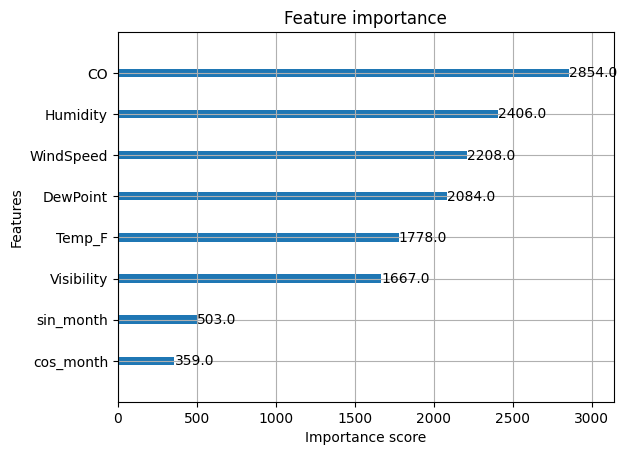

In [45]:
dtrain = xgb.DMatrix(xgb_train_co, label = train_co_actual)
dtest = xgb.DMatrix(xgb_test_co, label=test_co_actual)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'eta': 0.05,               # Lower learning rate
    'max_depth': 8,            # Slightly deeper trees
    'subsample': 0.8,          # Random subset of samples
    'colsample_bytree': 0.8,   # Random subset of features
    'alpha': 0.1,              # L1 regularization
    'lambda': 1.0,             # L2 regularization
    'seed': 42
}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=2000,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    early_stopping_rounds=50,
    verbose_eval=50
)

train_pred = model.predict(dtrain)
test_pred = model.predict(dtest)

print(f"Training MAE: {mean_absolute_error(train_co_actual, train_pred):.2f}")
print(f"Test MAE: {mean_absolute_error(test_co_actual, test_pred):.2f}")


xgb.plot_importance(model)
plt.show()

